# Feature Engineering

## Provided Description

Dataset Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions

1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
2. test.csv - the test set. **You need to forecast the sales for these shops and products for November 2015.**
3. sample_submission.csv - a sample submission file in the correct format.
4. items.csv - supplemental information about the items/products.
5. item_categories.csv - supplemental information about the items categories.
6. shops.csv- supplemental information about the shops.

Data fields

1. ID - an Id that represents a (Shop, Item) tuple within the test set
2. shop_id - unique identifier of a shop
3. item_id - unique identifier of a product
4. item_category_id - unique identifier of item category
5. item_cnt_day - number of products sold. **You are predicting a monthly amount of this measure**
6. item_price - current price of an item
7. date - date in format dd/mm/yyyy
8. date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
9. item_name - name of item
10. shop_name - name of shop
11. item_category_name - name of item category

This challenge serves as final project for the "How to win a data science competition" Coursera course.
https://www.coursera.org/learn/competitive-data-science/home/welcome

In this competition you will work with a challenging time-series dataset consisting of daily sales data, 
kindly provided by one of the largest Russian software firms - 1C Company. https://1c.ru/eng/title.htm

We are asking you to **predict total sales for every product and store in the next month.** By solving this competition you will be able to apply and enhance your data science skills.

## 1. Loading libraries and loading data into dataframes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Copy data (competitive-data-science-final-project.zip) one level before the current directory
# and extract once. 
# Secondary extraction is done with pandas read_csv

In [3]:
# Dropping this table as it is as same as item_categories and not mentioned in the initial data description
# df_item_cats = pd.read_csv('competitive-data-science-final-project/item_cats.csv')

In [4]:
df_item_categories = pd.read_csv('../competitive-data-science-final-project/item_categories.csv')

In [5]:
df_items = pd.read_csv('../competitive-data-science-final-project/items.csv')

In [6]:
df_shops = pd.read_csv('../competitive-data-science-final-project/shops.csv')

In [7]:
df_train = pd.read_csv('../competitive-data-science-final-project/sales_train.csv.gz', compression='gzip')

In [8]:
df_test = pd.read_csv('../competitive-data-science-final-project/test.csv.gz', compression='gzip')

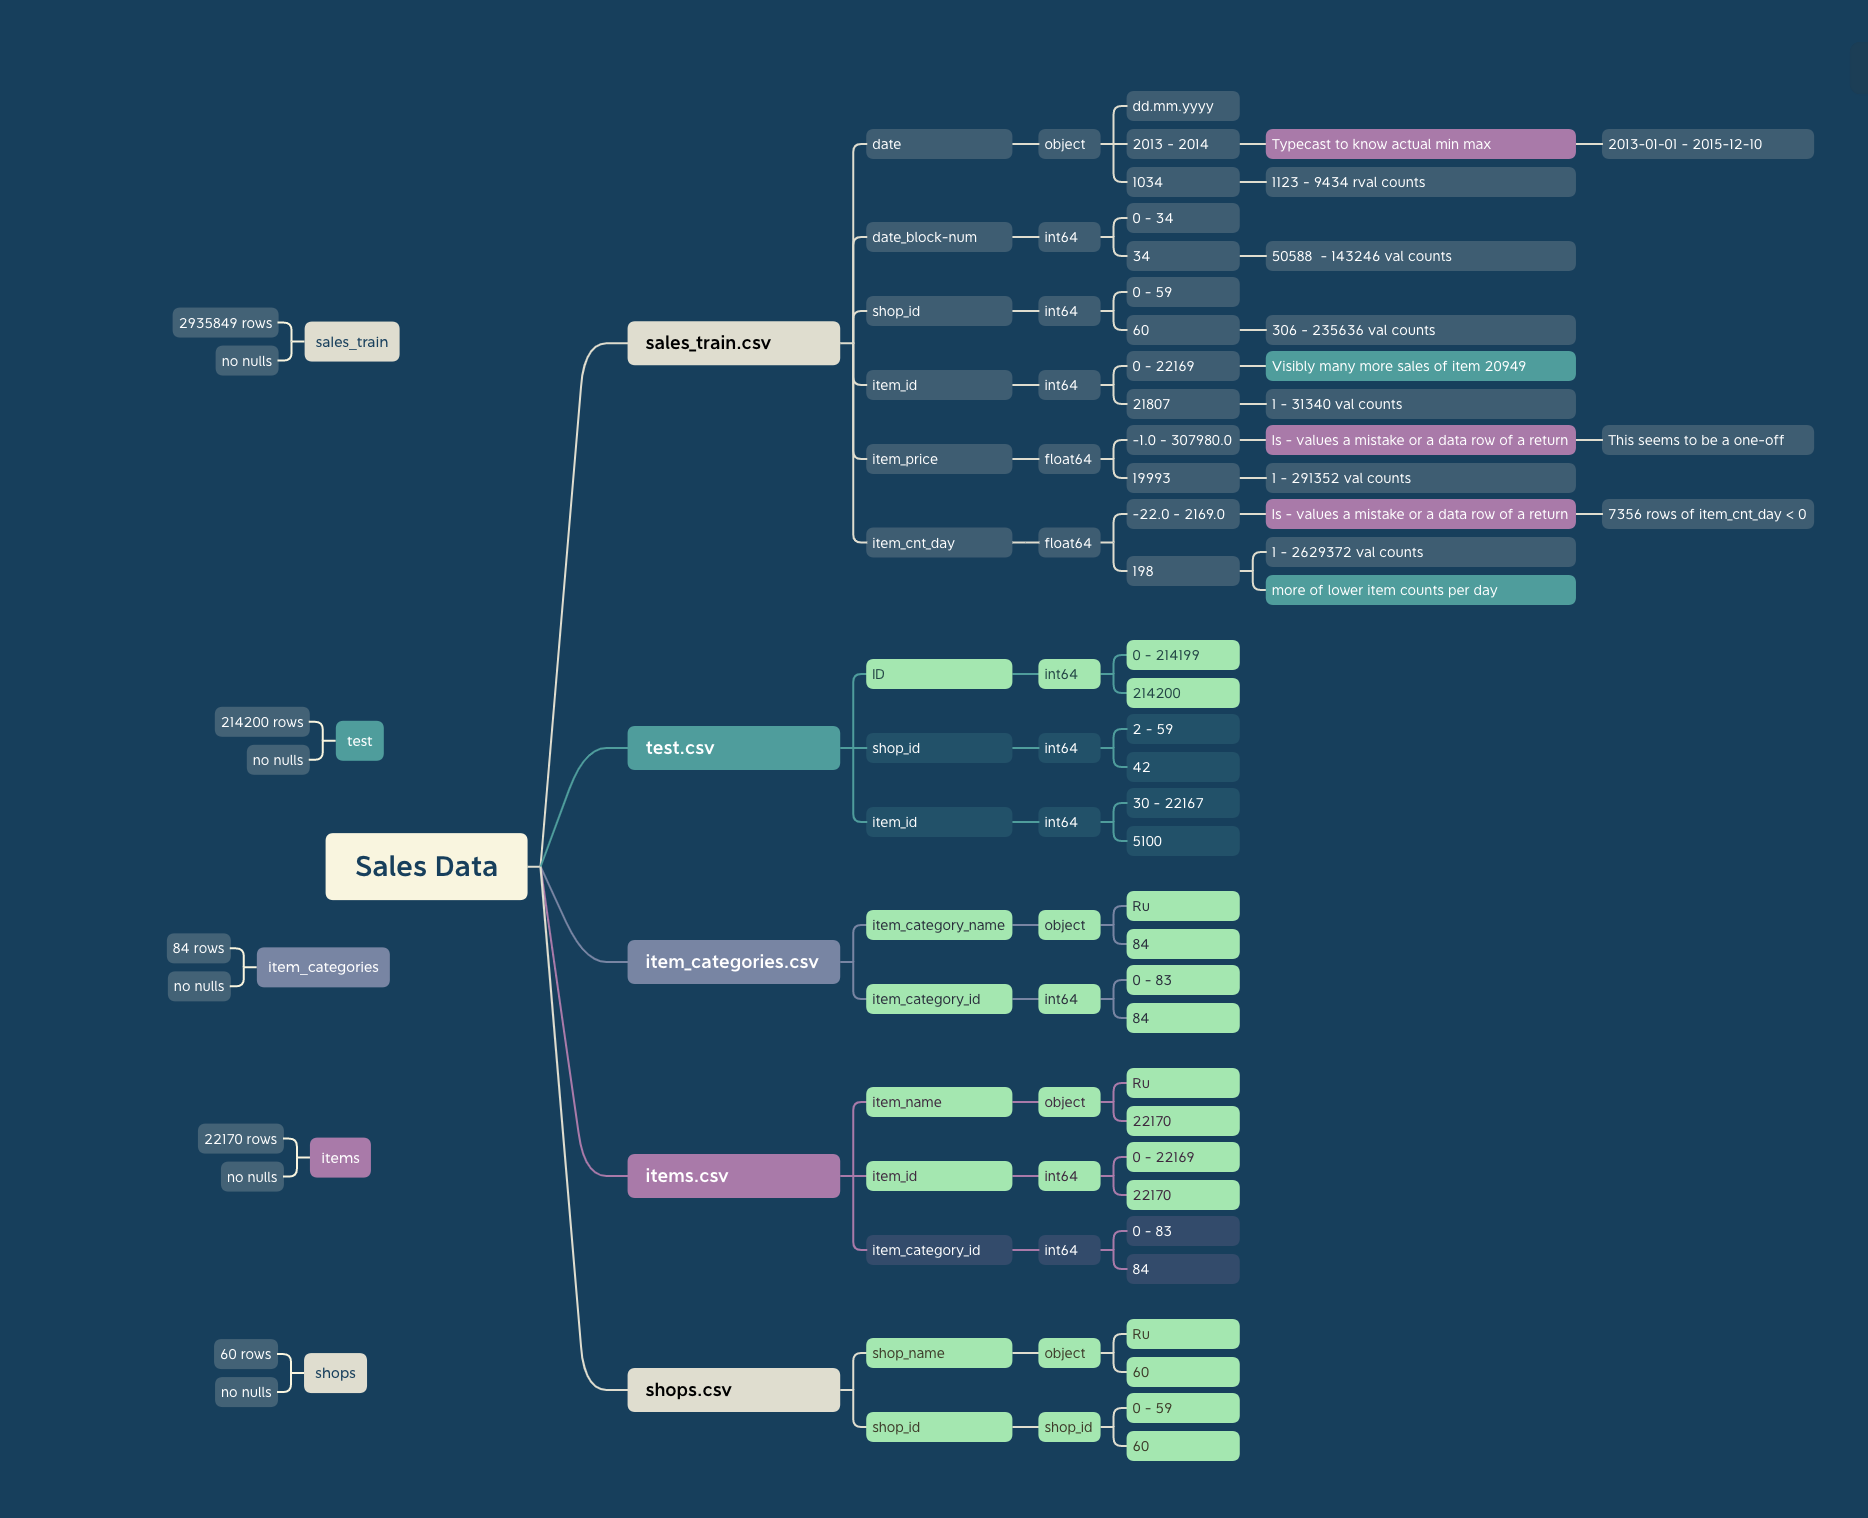

# Learnings from Exploratory Analysis

* Update the item_price = - 1.0 cell to the mean price of that item. Or drop.

1. Type cast date column

2. Remove the 6 duplicates in the df_train 

3. Update the item_price = - 1.0 cell to the mean price of that item. Or drop.

4. Merge rows with different item price for same item to get one item_count?

5. Remove the current ID column in the df_test and if required maybe add a column with a delimiter so it can later be constructed/deconstructed/identified against shop_id and item_id.


* Add Year_Month column. maybe? And week of year and day of week column. maybe ??

* Maybe add item category ID column to both testing and training datasets?

* Do we need to keep items from the category IDs not present in the testing dataset? 

* Should we keep the data outside of the 5100 unique item_ids and 42 unique shop ID's used in the test dataset?

# Feature Engineering Steps

## 1. Typecasting the date column, inplace

In [9]:
df_train['date']= pd.to_datetime(df_train['date'], dayfirst=True)

In [10]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


## 2. Remove the 6 duplicates in the df_train

In [13]:
df_train.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [15]:
df_train.drop_duplicates().count()

date              2935843
date_block_num    2935843
shop_id           2935843
item_id           2935843
item_price        2935843
item_cnt_day      2935843
dtype: int64

In [16]:
df_train.drop_duplicates(inplace = True)

In [17]:
df_train.count()

date              2935843
date_block_num    2935843
shop_id           2935843
item_id           2935843
item_price        2935843
item_cnt_day      2935843
dtype: int64

## 3. Update the item_price = - 1.0 cell

In [21]:
# This is not even necessary if we are dropping the column later. 
#But in case we are not; here goes;

In [22]:
df_train.head()
df_train.loc[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [ ]:
# figuring out the item price for item_id = 2973

In [31]:
temp_df_item_price = df_train.loc[df_train.item_id == 2973]
temp_df_item_price.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,2013-01-15,0,25,2973,2499.0,13.0
353,2013-01-16,0,25,2973,2499.0,5.0
354,2013-01-17,0,25,2973,2499.0,3.0
355,2013-01-18,0,25,2973,2499.0,2.0
356,2013-01-19,0,25,2973,2499.0,3.0


In [38]:
print("mean: ", temp_df_item_price.item_price.mean())
print("median: ", temp_df_item_price.item_price.median())
print("mode: ", temp_df_item_price.item_price.mode())
print("range: ", temp_df_item_price.item_price.max() - 
      temp_df_item_price.item_price.min())

mean:  2041.6272774725257
median:  2499.0
mode:  0    2499.0
Name: item_price, dtype: float64
range:  2500.0


In [41]:
# Assign the modal value for item_price in place of the minus value

df_train.item_price = df_train.item_price.replace(-1.0, 2499.0)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [42]:
df_train.loc[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


## 4. Merge rows with different item price for same item to get one item_count

In [50]:
df_train[df_train.duplicated(
    subset = ["date", "shop_id", "item_id"], keep='last'
)].sort_values(by = "date")

# 70718	2013-01-25	0	31	14050	248.00	1.0 keep = 'first'
# 70686	2013-01-25	0	31	14050	349.00	1.0 keep = 'last'

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
70686,2013-01-25,0,31,14050,349.00,1.0
103461,2013-01-27,0,38,15702,549.00,1.0
6959,2013-01-29,0,25,12133,889.00,1.0
210156,2013-02-16,1,25,12133,1389.00,1.0
142696,2013-02-18,1,16,15702,149.00,1.0
284371,2013-03-02,2,16,12133,889.00,1.0
275474,2013-03-07,2,50,12133,1389.00,1.0
408103,2013-04-06,3,54,14050,198.00,1.0
1203857,2013-12-28,11,54,12133,669.00,1.0
1154619,2013-12-29,11,27,12133,999.00,1.0


In [62]:
# Dropping the price column 

In [65]:
df_train = df_train.groupby(
    ["date", "date_block_num", "shop_id", "item_id"]
)[["item_cnt_day"]].sum().reset_index()

In [67]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day
0,2013-01-01,0,2,991,1.0
1,2013-01-01,0,2,1472,1.0
2,2013-01-01,0,2,1905,1.0
3,2013-01-01,0,2,2920,2.0
4,2013-01-01,0,2,3320,1.0


In [68]:
df_train[df_train.duplicated(
    subset = ["date", "shop_id", "item_id"]
)].sort_values(by = "date")

,date,date_block_num,shop_id,item_id,item_cnt_day


## 5. Remove the current ID column in the df_test ?

In [72]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


** 

* ID in the test data set is not as the data description states

*  i.e.: (ID - an Id that represents a (Shop, Item) tuple within the test set)

* ID is not a tuple of Shop, Item combination. It is a number from the sequence starting from 0 assgned to each unique Shop_id, item_id pair, probably when data is rdered by shop_id.

## Maybe later?

In [220]:
# Adding a Month_Year column to validate the date_block_num column numbers

In [221]:
df_train['Month_Year'] = df_train['date'].dt.to_period('M')
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month_Year
0,2013-01-02,0,59,22154,999.00,1.0,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01


In [229]:
df_train.loc[df_train.duplicated(subset=None)].sort_values(["date", "shop_id","item_id"],
              ascending = True)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month_Year
76962,2013-01-05,0,54,20130,149.0,1.0,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,2014-12
